In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import feather

In [2]:
from datetime import date, datetime

In [3]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [4]:
data_path = '/Volumes/FileStorage/Insight_data/'
ohio_path = '/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/'

#oh_df = feather.read_dataframe(ohio_path+'oh_df_withvotenum.feather')
oh_df=feather.read_dataframe(ohio_path+'oh_train.feather')

In [5]:
election_list = []
election_i = []
general_list = []
primary_list = []
for key in oh_df:
        if key[:7]=='GENERAL':
                election_list.append(key)
                general_list.append(key)
        elif key[:7]=='PRIMARY':
                election_list.append(key)
                primary_list.append(key)
        elif key[:7]=='SPECIAL':
                election_list.append(key)
                
def el_to_date(election):
    el_date_str = election.split('-')[1]
    el_obj = datetime.strptime(el_date_str, '%m/%d/%Y')
    return el_obj
date_list = [el_to_date(e) for e in election_list]
date_dict = dict(zip(election_list, date_list))

In [6]:
def n_eligible_voted(row, start_date, end_date):
    reg_date = datetime.strptime(row['REGISTRATION_DATE'],'%Y-%m-%d')
    eligible_list = [l for l in election_list if date_dict[l]>reg_date and date_dict[l]>start_date and date_dict[l]<end_date]
    n_el = row[eligible_list].count()
    return n_el

In [7]:
def n_eligible(row, start_date, end_date):
    reg_date = datetime.strptime(row['REGISTRATION_DATE'],'%Y-%m-%d')
    eligible_list = [l for l in election_list if date_dict[l]>reg_date and date_dict[l]>start_date and date_dict[l]<end_date]
    return len(eligible_list)

In [8]:
date_2000=datetime(2000, 11, 7)
date_2004=datetime(2004,11,2)
date_2008=datetime(2008,11,4)
date_2012=datetime(2012,11,6)
date_2016=datetime(2016,11,8)
date_2020=datetime(2020,11,3)

In [10]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [11]:
oh_train, oh_validate, oh_test = train_validate_test_split(oh_df,seed=1)

In [18]:
oh_train = oh_train.drop(['N_VOTED_ELIGIBLE_2012','N_ELIGIBLE_2012','N_VOTED_ELIGIBLE_2016','N_ELIGIBLE_2016','N_VOTED_ELIGIBLE_2020','N_ELIGIBLE_2020','RATIO_2012','RATIO_2016','RATIO_2020'], axis=1)

In [19]:
oh_train.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,AGE_2016,AGE_2012,AGE_2020,N_VOTED_ELIGIBLE,N_ELIGIBLE
1999447,OH0011130136,20,7101009,SNIDER,LINDA,L,None,1941-06-04,1971-08-17,ACTIVE,...,X,R,None,X,X,75,71,79,35,60
2787541,OH0020250018,7,61454,SULLIVAN,LYNDSAY,MARIE,None,1977-06-20,2010-05-29,ACTIVE,...,None,None,None,None,None,39,35,43,2,28
2021961,OH0011554867,15,8002371,SPEARS,LAWRENCE,None,None,1940-05-14,1980-07-15,ACTIVE,...,X,None,None,None,None,76,72,80,25,60
837321,OH0016215163,6,5252,SCHMITMEYER,ERMA,R,None,1940-09-22,1979-09-24,ACTIVE,...,X,None,None,X,None,76,72,80,13,60
1307711,OH0011568971,10,9705724,BANTA,STARLA,L,None,1965-10-07,2002-03-19,ACTIVE,...,None,X,None,None,None,51,47,55,12,56


In [20]:
oh_train['N_VOTED_ELIGIBLE_2012'] = oh_train.progress_apply(lambda row: n_eligible_voted(row,date_2000,date_2012), axis=1)
oh_train['N_ELIGIBLE_2012'] = oh_train.progress_apply(lambda row: n_eligible(row,date_2000,date_2012), axis=1)

In [21]:
oh_train['N_VOTED_ELIGIBLE_2016'] = oh_train.progress_apply(lambda row: n_eligible_voted(row,date_2004,date_2016), axis=1)
oh_train['N_ELIGIBLE_2016'] = oh_train.progress_apply(lambda row: n_eligible(row,date_2004,date_2016), axis=1)

In [22]:
oh_train['N_VOTED_ELIGIBLE_2020'] = oh_train.progress_apply(lambda row: n_eligible_voted(row,date_2008,date_2020), axis=1)
oh_train['N_ELIGIBLE_2020'] = oh_train.progress_apply(lambda row: n_eligible(row,date_2008,date_2020), axis=1)

In [24]:
feather.write_dataframe(oh_train,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/train_subset.feather')

In [27]:
oh_train.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,AGE_2012,AGE_2020,N_VOTED_ELIGIBLE,N_ELIGIBLE,N_VOTED_ELIGIBLE_2012,N_ELIGIBLE_2012,N_VOTED_ELIGIBLE_2016,N_ELIGIBLE_2016,N_VOTED_ELIGIBLE_2020,N_ELIGIBLE_2020
1999447,OH0011130136,20,7101009,SNIDER,LINDA,L,None,1941-06-04,1971-08-17,ACTIVE,...,71,79,35,60,22,37,21,42,17,35
2787541,OH0020250018,7,61454,SULLIVAN,LYNDSAY,MARIE,None,1977-06-20,2010-05-29,ACTIVE,...,35,43,2,28,1,7,2,20,2,28
2021961,OH0011554867,15,8002371,SPEARS,LAWRENCE,None,None,1940-05-14,1980-07-15,ACTIVE,...,72,80,25,60,18,37,15,42,10,35
837321,OH0016215163,6,5252,SCHMITMEYER,ERMA,R,None,1940-09-22,1979-09-24,ACTIVE,...,72,80,13,60,6,37,8,42,9,35
1307711,OH0011568971,10,9705724,BANTA,STARLA,L,None,1965-10-07,2002-03-19,ACTIVE,...,47,55,12,56,8,35,9,42,7,35


In [25]:
def row_ratio(row,year):
    eligible_column = 'N_ELIGIBLE_'+year
    voted_column = 'N_VOTED_ELIGIBLE_'+year
    voted_i= row[voted_column]
    eligible_i = row[eligible_column]
    if eligible_i != 0:
        v_ratio = voted_i/eligible_i
    else:
        v_ratio = float('Inf')
    return v_ratio

In [29]:
oh_train['RATIO_2012'] = oh_train.progress_apply(lambda row: row_ratio(row,'2012'), axis=1)

In [30]:
oh_train['RATIO_2016'] = oh_train.progress_apply(lambda row: row_ratio(row,'2016'), axis=1)

In [31]:
oh_train['RATIO_2020'] = oh_train.progress_apply(lambda row: row_ratio(row,'2020'), axis=1)

In [32]:
feather.write_dataframe(oh_train,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/train_subset.feather')

In [33]:
%matplotlib inline

In [40]:
oh_train.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,N_ELIGIBLE,N_VOTED_ELIGIBLE_2012,N_ELIGIBLE_2012,N_VOTED_ELIGIBLE_2016,N_ELIGIBLE_2016,N_VOTED_ELIGIBLE_2020,N_ELIGIBLE_2020,RATIO_2012,RATIO_2016,RATIO_2020
1999447,OH0011130136,20,7101009,SNIDER,LINDA,L,None,1941-06-04,1971-08-17,ACTIVE,...,60,22,37,21,42,17,35,0.594595,0.500000,0.485714
2787541,OH0020250018,7,61454,SULLIVAN,LYNDSAY,MARIE,None,1977-06-20,2010-05-29,ACTIVE,...,28,1,7,2,20,2,28,0.142857,0.100000,0.071429
2021961,OH0011554867,15,8002371,SPEARS,LAWRENCE,None,None,1940-05-14,1980-07-15,ACTIVE,...,60,18,37,15,42,10,35,0.486486,0.357143,0.285714
837321,OH0016215163,6,5252,SCHMITMEYER,ERMA,R,None,1940-09-22,1979-09-24,ACTIVE,...,60,6,37,8,42,9,35,0.162162,0.190476,0.257143
1307711,OH0011568971,10,9705724,BANTA,STARLA,L,None,1965-10-07,2002-03-19,ACTIVE,...,56,8,35,9,42,7,35,0.228571,0.214286,0.200000


In [103]:
traits=['AGE_2016','GENERAL-11/06/2012','RATIO_2016', 'GENERAL-11/08/2016']
traits_plot=['Age','Voted 2012','Ratio(Voted/Elections)','Voted 2016']
oh_train[traits].dtypes

AGE_2016                int64
GENERAL-11/06/2012       int8
RATIO_2016            float64
GENERAL-11/08/2016       int8
dtype: object

In [84]:
oh_train=oh_train.astype({'RESIDENTIAL_ZIP': 'category'})
oh_train['RESIDENTIAL_ZIP'] = oh_train['RESIDENTIAL_ZIP'].astype('category')

In [85]:
oh_train.astype({'GENERAL-11/06/2012': 'category'})
oh_train.astype({'GENERAL-11/08/2016': 'category'})
oh_train['GENERAL-11/06/2012'] = oh_train['GENERAL-11/06/2012'].astype('category')
oh_train['GENERAL-11/08/2016'] = oh_train['GENERAL-11/08/2016'].astype('category')

In [94]:
oh_train['GENERAL-11/06/2012'].head()

1999447      X
2787541    NaN
2021961      X
837321       X
1307711      X
Name: GENERAL-11/06/2012, dtype: category
Categories (1, object): [X]

In [100]:
el_train_list=['GENERAL-11/06/2012','GENERAL-11/08/2016']
oh_train['GENERAL-11/06/2012'].cat.codes.head()
oh_train[el_train_list] = oh_train[el_train_list].progress_apply(lambda x: x.cat.codes)

In [104]:
correlations=oh_train[traits].corr()
print(correlations)

                    AGE_2016  GENERAL-11/06/2012  RATIO_2016  \
AGE_2016            1.000000            0.449604    0.459828   
GENERAL-11/06/2012  0.449604            1.000000    0.510865   
RATIO_2016          0.459828            0.510865    1.000000   
GENERAL-11/08/2016  0.333517            0.509555    0.477048   

                    GENERAL-11/08/2016  
AGE_2016                      0.333517  
GENERAL-11/06/2012            0.509555  
RATIO_2016                    0.477048  
GENERAL-11/08/2016            1.000000  


['Age', 'Voted 2012', 'Ratio(Voted/Elections)', 'Voted 2016']


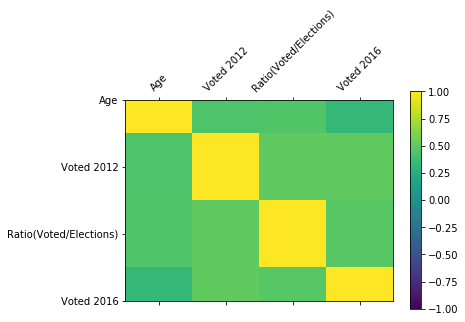

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
print(traits_plot)
ax.set_xticks(np.arange(0,correlations.shape[0], correlations.shape[0]*1.0/len(traits_plot)))
ax.set_yticks(np.arange(0,correlations.shape[1], correlations.shape[1]*1.0/len(traits_plot)))
ax.set_xticklabels(traits_plot,rotation=45)
ax.set_yticklabels(traits_plot)
plt.show()

[Text(0, 0.5, 'Voters'), Text(0.5, 0, '#Presidential elections')]

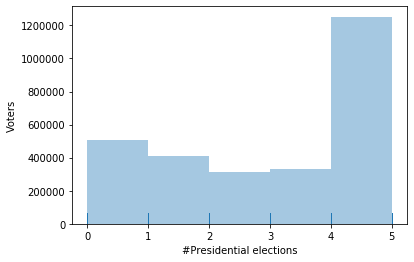

In [57]:
import seaborn

presidential_list=['GENERAL-11/07/2000','GENERAL-11/02/2004','GENERAL-11/04/2008','GENERAL-11/06/2012','GENERAL-11/08/2016']
presidential_n=oh_train[presidential_list].notnull().sum(axis=1)
ax = seaborn.distplot(presidential_n,bins=5,kde=False, rug=True);
ax.set(xlabel='#Presidential elections', ylabel='Voters')

In [114]:
X_train = oh_train.loc[:, traits]

In [115]:
X_train.shape

(2817138, 4)

In [163]:
Y_train=oh_train['GENERAL-11/08/2016']

In [120]:
Y_train.shape

(2817138,)

In [133]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

In [191]:
X_train['RATIO_2016']=X_train['RATIO_2016'].replace(float('Inf'), 0)

In [192]:
np.isfinite(X_train).all()

AGE_2016              True
GENERAL-11/06/2012    True
RATIO_2016            True
GENERAL-11/08/2016    True
dtype: bool

In [170]:
np.any(np.isnan(Y_train))

False

In [169]:
np.all(np.isfinite(X_train))

False

In [165]:
Y_train.reset_index(drop=True, inplace=True)
np.all(np.isfinite(Y_train))

True

In [179]:
val_mask = Y_train == np.nan

In [180]:
Y_train[val_mask].index

Int64Index([], dtype='int64')

In [193]:
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [194]:
from joblib import dump, load
dump(logreg, 'logreg.joblib') 

['logreg.joblib']

In [197]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, Y_test)
print(score)

1.0


In [198]:
for key in oh_train:
    print(key)

SOS_VOTERID
COUNTY_NUMBER
COUNTY_ID
LAST_NAME
FIRST_NAME
MIDDLE_NAME
SUFFIX
DATE_OF_BIRTH
REGISTRATION_DATE
VOTER_STATUS
PARTY_AFFILIATION
RESIDENTIAL_ADDRESS1
RESIDENTIAL_SECONDARY_ADDR
RESIDENTIAL_CITY
RESIDENTIAL_STATE
RESIDENTIAL_ZIP
RESIDENTIAL_ZIP_PLUS4
RESIDENTIAL_COUNTRY
RESIDENTIAL_POSTALCODE
MAILING_ADDRESS1
MAILING_SECONDARY_ADDRESS
MAILING_CITY
MAILING_STATE
MAILING_ZIP
MAILING_ZIP_PLUS4
MAILING_COUNTRY
MAILING_POSTAL_CODE
CAREER_CENTER
CITY
CITY_SCHOOL_DISTRICT
COUNTY_COURT_DISTRICT
CONGRESSIONAL_DISTRICT
COURT_OF_APPEALS
EDU_SERVICE_CENTER_DISTRICT
EXEMPTED_VILL_SCHOOL_DISTRICT
LIBRARY
LOCAL_SCHOOL_DISTRICT
MUNICIPAL_COURT_DISTRICT
PRECINCT_NAME
PRECINCT_CODE
STATE_BOARD_OF_EDUCATION
STATE_REPRESENTATIVE_DISTRICT
STATE_SENATE_DISTRICT
TOWNSHIP
VILLAGE
WARD
PRIMARY-03/07/2000
GENERAL-11/07/2000
SPECIAL-05/08/2001
GENERAL-11/06/2001
PRIMARY-05/07/2002
GENERAL-11/05/2002
SPECIAL-05/06/2003
GENERAL-11/04/2003
PRIMARY-03/02/2004
GENERAL-11/02/2004
SPECIAL-02/08/2005
PRIMARY-05

In [202]:
print(oh_train[['PRECINCT_NAME','PRECINCT_CODE']])

                              PRECINCT_NAME PRECINCT_CODE
1999447                      HICKSVILLE TWP         20ABA
2787541                   PRECINCT YORK TWP         07ADK
2021961      PRECINCT SALEM TWP FRANKLIN SQ         15AEM
837321                PRECINCT NEW BREMEN E         06AAV
1307711                          HARRISON A         10AAX
17389                 WARRENSVILLE HTS-02-B      18-P-DEL
1128634                       WESTLAKE-03-D      18-P-CYX
1745892             UNIVERSITY HEIGHTS-00-C      18-P-CWQ
967256                     SEVEN HILLS-01-A      18-P-CPM
2635666                            MIDD7WD2      09-P-ADW
463276         PRECINCT GREENVILLE CITY 3-A         19AAG
3885527                      CLEVELAND-15-F      18-P-BDW
2744621                      CLEVELAND-16-C      18-P-BHU
979114                  PRECINCT KINGSTON A         21ACL
4028097                      CLEVELAND-01-Q      18-P-AIX
4624659               GARFIELD HEIGHTS-06-A      18-P-BUA
2002768       